<a href="https://colab.research.google.com/github/ThierrryScotto/fer_recognition_using_frequency_neural_network/blob/master/basic_FreNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from PIL import Image
from scipy.fftpack import dct

2024-08-01 23:20:25.203106: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 23:20:25.206730: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 23:20:25.221249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 23:20:25.245605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 23:20:25.253764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 23:20:25.271734: I tensorflow/core/platform/cpu_feature_gu

# Importing dataset

In [2]:
# df_ck_plus = pd.read_csv('./Datasets/ckextended.csv')
URL = "./datasets/ckextended.csv"
df_ck_plus = pd.read_csv(URL)
df_ck_plus

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training
...,...,...,...
915,5,87 86 88 92 92 127 231 248 251 253 254 254 254...,PrivateTest
916,5,21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...,PrivateTest
917,5,76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...,PrivateTest
918,5,114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...,PrivateTest


## Download of shape_predictor

In [3]:
from src.models import ShapePredictor

ShapePredictor()

Arquivo descompactado salvo em: ./models/shape_predictor_68_face_landmarks.bz2
Arquivo descompactado com sucesso!


## Converting 1D vectors to images

In [4]:
HEIGHT = 48
WIDTH = 48
OUTPUT_FOLDER = './images/input_images'
os.makedirs(OUTPUT_FOLDER, exist_ok=False)
OUTPUT_PATH = os.path.join(OUTPUT_FOLDER, 'reconstructed_image')

FileExistsError: [Errno 17] File exists: './images/input_images'

In [ ]:
df_ck_plus.shape

(920, 3)

In [ ]:
images_label = []

for index, row in df_ck_plus.iterrows():
  one_dimensional_str = row['pixels'].split()
  one_dimensional_vec = np.array(list(map(int, one_dimensional_str)))

  if one_dimensional_vec.size == HEIGHT * WIDTH:
    image_2d = one_dimensional_vec.reshape((HEIGHT, WIDTH))
    plt.imsave(f"{OUTPUT_PATH}_{index}_emotion_{row['emotion']}_.png", image_2d, cmap='gray')
    images_label.append(row['emotion'])
  else:
    print()
    raise ValueError(f"The size of the vector {one_dimensional_vec.size} does not correspond to the product of the dimensions ({HEIGHT}, {WIDTH})")

#Image pre-processing

In [54]:
import dlib
from PIL import Image
import numpy as np
import os

def adjust_and_crop_face(image_path, output_folder):
    # Carregar a imagem
    image = dlib.load_rgb_image(image_path)

    # Inicializar o detector de rostos e o preditor de pontos-chave
    detector = dlib.get_frontal_face_detector()

    # Caminho completo para o arquivo shape_predictor_68_face_landmarks.dat
    dat_file_path = '../models/shape_predictor_68_face_landmarks.dat'
    # Carregar o preditor de forma
    predictor = dlib.shape_predictor(dat_file_path)

    # Detectar os rostos na imagem
    faces = detector(image, 1)

    # Criar a pasta de saída, se não existir
    os.makedirs(output_folder, exist_ok=True)

    # Processar cada rosto detectado
    for i, face in enumerate(faces):
        # Obter os pontos chave do rosto
        landmarks = predictor(image, face)

        # Converter os pontos chave para um formato utilizável
        face_landmarks = {
            "left_eye": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(36, 42)],
            "right_eye": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(42, 48)],
            "left_eyebrow": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(17, 22)],
            "right_eyebrow": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(22, 27)],
            "chin": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(0, 17)],
        }

        # Obter os pontos dos olhos, sobrancelhas e queixo
        left_eye = np.array(face_landmarks['left_eye'])
        right_eye = np.array(face_landmarks['right_eye'])
        left_eyebrow = np.array(face_landmarks['left_eyebrow'])
        right_eyebrow = np.array(face_landmarks['right_eyebrow'])
        chin = np.array(face_landmarks['chin'])

        # Calcular o ponto médio entre os olhos
        left_eye_center = left_eye.mean(axis=0)
        right_eye_center = right_eye.mean(axis=0)
        eye_center = ((left_eye_center + right_eye_center) / 2).astype(int)

        # Calcular o ângulo para horizontalizar os olhos
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dy, dx))

        # Rotacionar a imagem para horizontalizar os olhos
        pil_image = Image.fromarray(image)
        pil_image = pil_image.rotate(angle, center=tuple(eye_center), expand=True)

        # Recalcular os pontos chave após rotação
        rotated_image = np.array(pil_image)
        rotated_faces = detector(rotated_image, 1)
        rotated_landmarks = predictor(rotated_image, rotated_faces[0])

        # Obter os novos pontos chave para sobrancelhas e queixo
        left_eyebrow = np.array([(rotated_landmarks.part(j).x, rotated_landmarks.part(j).y) for j in range(17, 22)])
        right_eyebrow = np.array([(rotated_landmarks.part(j).x, rotated_landmarks.part(j).y) for j in range(22, 27)])
        chin = np.array([(rotated_landmarks.part(j).x, rotated_landmarks.part(j).y) for j in range(0, 17)])

        # Calcular o topo das sobrancelhas e o fundo do queixo
        top_of_eyebrows = min(left_eyebrow[:,1].min(), right_eyebrow[:,1].min())
        bottom_of_chin = chin[:,1].max()

        # Calcular as coordenadas do recorte
        top = top_of_eyebrows
        bottom = bottom_of_chin
        left = min(chin[:,0].min(), left_eyebrow[:,0].min(), right_eyebrow[:,0].min())
        right = max(chin[:,0].max(), left_eyebrow[:,0].max(), right_eyebrow[:,0].max())

        # Recortar a imagem
        cropped_face = pil_image.crop((left, top, right, bottom))

        # Salvar a imagem recortada com o nome original acrescido de "face"
        base_filename, ext = os.path.splitext(os.path.basename(image_path))
        face_image_path = os.path.join(output_folder, f'{base_filename}_face{ext}')
        cropped_face.save(face_image_path)
        print(f'Rosto {i+1} salvo em {face_image_path}')

# Caminho para a pasta de entrada
input_folder = './images/input_images/'

# Pasta para salvar os rostos recortados
output_folder = './images/preprocessed_images'

# # Processar cada imagem na pasta de entrada
# for filename in os.listdir(input_folder):
#     if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
#         image_path = os.path.join(input_folder, filename)
#         adjust_and_crop_face(image_path, output_folder)


# Carregar as imagens do output_folder em uma matriz de arrays
image_arrays = []
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path).convert('L')
        image_array = np.array(image)
        image_arrays.append(image_array)

# Converter a lista de arrays em uma matriz de arrays
image_matrix = np.array(image_arrays)

print("Matriz de arrays das imagens:")
print(image_matrix[0])

Matriz de arrays das imagens:
[[ 6  2  0 ... 86 84 84]
 [ 0  0  0 ... 78 84 86]
 [ 0  0  0 ... 77 86 86]
 ...
 [64 64 65 ... 72 68 73]
 [64 70 69 ... 73 70 70]
 [60 65 65 ... 72 70 69]]


# DCT and CIE Layer

Getting one image of example

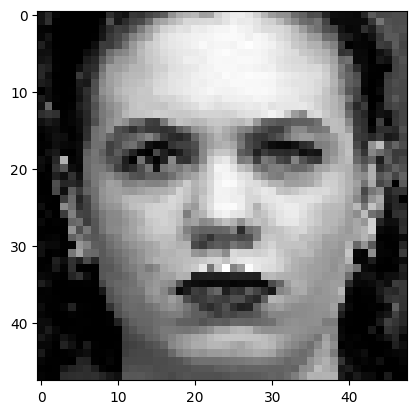

In [57]:
# image_matrix[0]

plt.imshow(image_matrix[800], cmap='gray')

In [58]:
images_label[0]

NameError: name 'images_label' is not defined

**using the gamma parameter to reduce the image size**

In [59]:
γ = 0.25

def resize_dct(dct_image, gamma):
    h, w = dct_image.shape
    new_h, new_w = int(h * gamma), int(w * gamma)
    return dct_image[:new_h, :new_w]

verificando a escala das imagens

In [60]:
print(len(image_matrix))
print(len(images_label))

920


NameError: name 'images_label' is not defined

### Applying the DCT and CIE transforms

In [64]:
def apply_dct_to_imagesdef(image_matrix):
    dct_images = []
    for index in range(image_matrix.shape[0]):
        image = image_matrix[index]
        dct_image = dct(dct(image.T, norm='ortho').T, norm='ortho')
        dct_images.append(resize_dct(dct_image, γ))
    return np.array(dct_images)

In [65]:
frequency_input = apply_dct_to_imagesdef(image_matrix)
print(frequency_input[0])

[[ 4.02083333e+03 -6.07645380e+02 -1.06149245e+03  8.72387056e+01
   1.33665554e+02  8.56993835e+01  1.92032973e+01  4.05792828e+00
   2.61575845e+02 -1.07255942e+02  9.90085805e+01 -3.19915584e+01]
 [ 3.21957860e+02 -2.05755119e+02 -9.44882762e+02 -1.12968438e+02
   2.55045230e+02  9.02218017e+01  6.31029382e+01 -2.61204999e+01
   1.42035116e+02 -3.95473662e+01  1.05529402e+02 -3.30900270e+01]
 [-2.50579605e+02  1.22278190e+02 -2.98329434e+02 -1.34018990e+01
   1.71838759e+02 -4.14013782e+00  1.57817615e+02 -1.34518963e+02
  -1.80668979e+02 -4.43100355e+01  1.02288457e+02 -5.52813449e+00]
 [ 2.58299139e+02 -6.60553167e+00 -4.09991277e+02  6.23375169e+01
  -5.70614291e+01 -6.74281436e+01  2.95315293e+02 -3.17221596e+01
  -3.42100812e+01 -1.19389091e+02 -1.11825943e+02 -1.60669804e+01]
 [ 3.10718059e+02 -1.37369351e+02 -3.33952014e+02  8.48031203e+01
   2.23633829e+02 -9.99265808e+01 -9.46940908e+01 -3.13218722e+01
   2.92768242e+01 -4.46176175e+01 -3.01711090e+01  2.46022541e+01]
 [-4.

In [ ]:
# Vetor 2D
# frequency_input = []

# for index in range(len(image_matrix)):
#     transformed_image = dct(dct(image_matrix[index].T, norm='ortho').T, norm='ortho')
#     frequency_input.append(resize_dct(transformed_image, γ))
#     # frequency_input.append(dct(dct(image_arrays[index].T, norm='ortho').T, norm='ortho'))

# print(frequency_input[0])

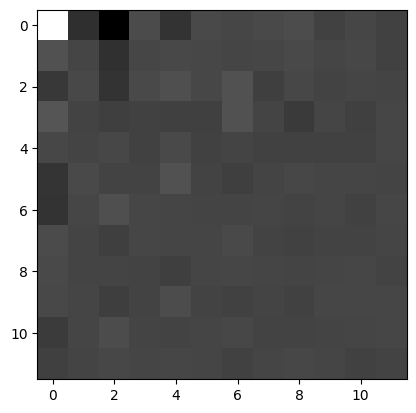

In [67]:
plt.imshow(frequency_input[100], cmap='gray')
plt.show()

# Basic-FreNet

**Paremeters**

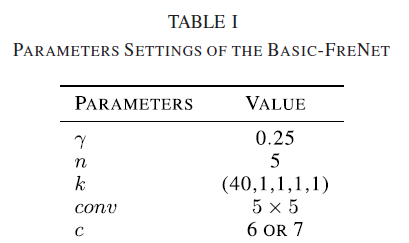

In [ ]:
n = 5
k = [40, 1, 1, 1, 1]
conv = 5
c = 6

In [ ]:

# Função para criar uma camada convolucional com inicialização de distribuição normal truncada
def conv_layer(input_tensor, num_filters, kernel_size, name):
    with tf.variable_scope(name):
        in_channels = input_tensor.get_shape()[-1]
        weights = tf.get_variable('weights',
                                  shape=[kernel_size, kernel_size, in_channels, num_filters],
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        biases = tf.get_variable('biases',
                                 shape=[num_filters],
                                 initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_tensor, weights, strides=[1, 1, 1, 1], padding='SAME')
        output = tf.nn.relu(conv + biases)
    return output

# Placeholder para a entrada
# input_shape = (None, 40, 40, 1)  # Exemplo de entrada (ajustar conforme necessário)
# inputs = tf.placeholder(tf.float32, shape=input_shape)

# Camadas convolucionais conforme especificadas
conv1 = conv_layer(frequency_input, k[0], 5, 'conv1')
conv2 = conv_layer(conv1, k[1], 5, 'conv2')
conv3 = conv_layer(conv2, k[2], 5, 'conv3')
conv4 = conv_layer(conv3, k[3], 5, 'conv4')
conv5 = conv_layer(conv4, k[4], 5, 'conv5')

# Definir a sessão do TensorFlow
sess = tf.Session()

# Inicializar variáveis
sess.run(tf.global_variables_initializer())

# Exemplo de dados de entrada
input_data = np.random.random((1, 40, 40, 1))

# Fazer uma previsão
output_data = sess.run(conv5, feed_dict={inputs: input_data})
print("Output shape:", output_data.shape)


In [ ]:
import tensorflow as tf

# Definindo a função de inicialização com distribuição normal truncada
def truncated_normal_init(shape, dtype=None):
    return tf.random.truncated_normal(shape, stddev=0.1, dtype=dtype)

# Parâmetros do modelo
n = 5
k = [40, 1, 1, 1, 1]
conv_kernel_size = 5
c = 6  # ou 7

# Placeholder para a entrada
# input_image = tf.keras.layers.Input(shape=(128, 128, 1))

# Construindo as camadas LMK com filtros de multiplicação
x = frequency_input
for filters in k:
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=(conv_kernel_size, conv_kernel_size),
        padding='same',
        kernel_initializer=truncated_normal_init)(x)

# Adicionando camada de convolução e pooling
x = tf.keras.layers.Conv2D(
    filters=c,
    kernel_size=(conv_kernel_size, conv_kernel_size),
    padding='same',
    kernel_initializer=truncated_normal_init)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Adicionando camadas totalmente conectadas para classificação
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(c, activation='softmax')(x)

# Definindo o modelo
model = tf.keras.Model(inputs=frequency_input, outputs=output)

# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()
